<a href="https://colab.research.google.com/github/williambjames/nflFastR/blob/master/in_depth_Comparative_Val.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style

In [2]:
pip install adjustText

In [4]:
from adjustText import adjust_text

In [5]:
df = pd.read_csv('https://github.com/guga31bb/nflfastR-data/blob/master/data/' \
                         'play_by_play_2020.csv.gz?raw=True',
                         compression='gzip', low_memory=False)

In [6]:
df.shape

(43338, 340)

In [7]:
qbs = df.groupby(['passer','posteam','game_id'],as_index=False).agg({'play_id':'count'}) #group all qbs and find total play count

In [8]:
qb_game = qbs.loc[(qbs['play_id']>14)] #a valid game will have 15 or more plays

In [10]:
qb_season = qb_game.groupby(['passer','posteam'],as_index=False).agg({'game_id':'nunique'}) #group by passer, look at total valid games in a season
qb_season = qb_season.loc[(qb_season['game_id']>7)] #a valid season will have 8 or more valid games

In [11]:
qb_game = qb_game.loc[(qb_game['passer'].isin(qb_season['passer']))] #loc the data to only worry about quarterbacks with a valid season, show by individual game

In [12]:
games = df.loc[(df['game_id'].isin(qb_game['game_id']))] #create new DF from original PBP containing only games from valid QBs

In [13]:
teams_o = games.groupby(['posteam'],as_index=False).agg({'epa':'sum','play_id':'count'}) #group by offense, find total plays and total EPA
teams_d = games.groupby(['defteam'],as_index=False).agg({'epa':'sum','play_id':'count'})# group by defense, find total plays and total EPA

In [14]:
teams_o = teams_o.rename(columns={'posteam':'team','epa':'pos_epa','play_id':'o_play'}) #rename columns
teams_d = teams_d.rename(columns={'defteam':'team','epa':'def_epa','play_id':'d_play'})

In [15]:
total = pd.merge(teams_o[['team', 'pos_epa', 'o_play']],teams_d[['team', 'def_epa', 'd_play']]) #merge team_o and team_d into one DF

In [16]:
total['total'] = total['pos_epa'] + (-1*total['def_epa']) #create total team EPA (off + -1*def)
total['plays'] = total['o_play'] + total['d_play'] #total snaps

In [17]:
total['total_avg'] = total['total'].div(total['plays']) #average total EPA per play

In [18]:
qb_pass = games.loc[(games['passer'].isin(qb_game['passer']))].groupby(['passer','posteam'],as_index=False).agg({'qb_epa':'sum','play_id':'count'}) #group all valid qb games, find EPA of passes from QB and total plays
qb_rush = games.loc[(games['rusher'].isin(qb_game['passer']))].groupby(['rusher','posteam'],as_index=False).agg({'epa':'sum','play_id':'count'}) #group all valid qb games, find EPA of rushes from QB and total plays
qb_pass = qb_pass.rename(columns={'posteam':'team'}) #renaming for merge
qb_rush = qb_rush.rename(columns={'posteam':'team'})
qb_rush = qb_rush.rename(columns={'rusher':'passer','play_id':'rushes'}) #rename rusher to passer so we can combine rush/pass EPA's

In [19]:
qb = pd.merge(qb_pass,qb_rush[['passer','epa','rushes']],on=['passer']) #new DF merging rushing/passing plays based on passer name.
qb['tepa'] = qb['qb_epa'] + qb['epa'] #make Total EPA (h/t @ConorMcQ5 and his TEPA explanation after every college graph he tweets <3)
qb['plays'] = qb['play_id'] + qb['rushes'] #total plays in which the QB passes/runs
qb['avg_tepa'] = qb['tepa'].div(qb['plays']) #average TEPA per play

In [20]:
total = pd.merge(total, qb[['passer','team','tepa','avg_tepa']],on=['team']) #merge QB data into 'total' DF with team data, merged by team name

In [21]:
total['diff'] = total['tepa'].sub(total['total']) #difference between QB and team EPA
total['avg_diff'] = total['avg_tepa'].sub(total['total_avg']) #difference between average QB and average team EPA

In [22]:
COLORS = {'ARI':'#97233F','ATL':'#A71930','BAL':'#241773','BUF':'#00338D','CAR':'#0085CA','CHI':'#00143F', #ADD IN TEAM COLORS
          'CIN':'#FB4F14','CLE':'#FB4F14','DAL':'#B0B7BC','DEN':'#002244','DET':'#046EB4','GB':'#24423C',
          'HOU':'#C9243F','IND':'#003D79','JAX':'#136677','KC':'#CA2430','LA':'#002147','LAC':'#2072BA',
          'LV':'#C4C9CC','MIA':'#0091A0','MIN':'#4F2E84','NE':'#0A2342','NO':'#A08A58','NYG':'#192E6C',
          'NYJ':'#203731','PHI':'#014A53','PIT':'#FFC20E','SEA':'#7AC142','SF':'#C9243F','TB':'#D40909',
          'TEN':'#4095D1','WAS':'#FFC20F'}
COLORS2 = {"TB": "#FF7900", "DET": "#B0B7BC", "TEN": "#4B92DB", "BAL": "#000000", #SECONDARY COLORS
           "GB": "#203731", "MIA": "#008E97", "DAL": "#869397", "BUF": "#C60C30",
           "CLE": "#ff3c00", "HOU": "#A71930", "WAS": "#773141", "LAC": "#FFC20E",
           "CHI": "#0B162A", "KC": "#FFB81C", "NYJ": "#000000", "PHI": "#000000",
           "NYG": "#a71930", "IND": "#A2AAAD", "ATL": "#a71930", "MIN": "#FFC62F",
           "CAR": "#BFC0BF", "CIN": "#000000", "LA": "#002244", "ARI": "#97233F",
           "NE": "#002244", "SF": "#AA0000", "LV": "#000000", "JAX": "#9F792C",
           "PIT": "#101820", "NO": "#101820", "DEN": "#002244", "SEA": "#002244",
                         }

In [26]:
x = total['total']
y = total['tepa']
slope, intercept = np.polyfit(x, y, 1)
abline_values = [slope * i + intercept for i in x] #create line of best fit (linear)

Text(0.74, 0.03, 'Data: nflfastR | Graph: @wbjames_')

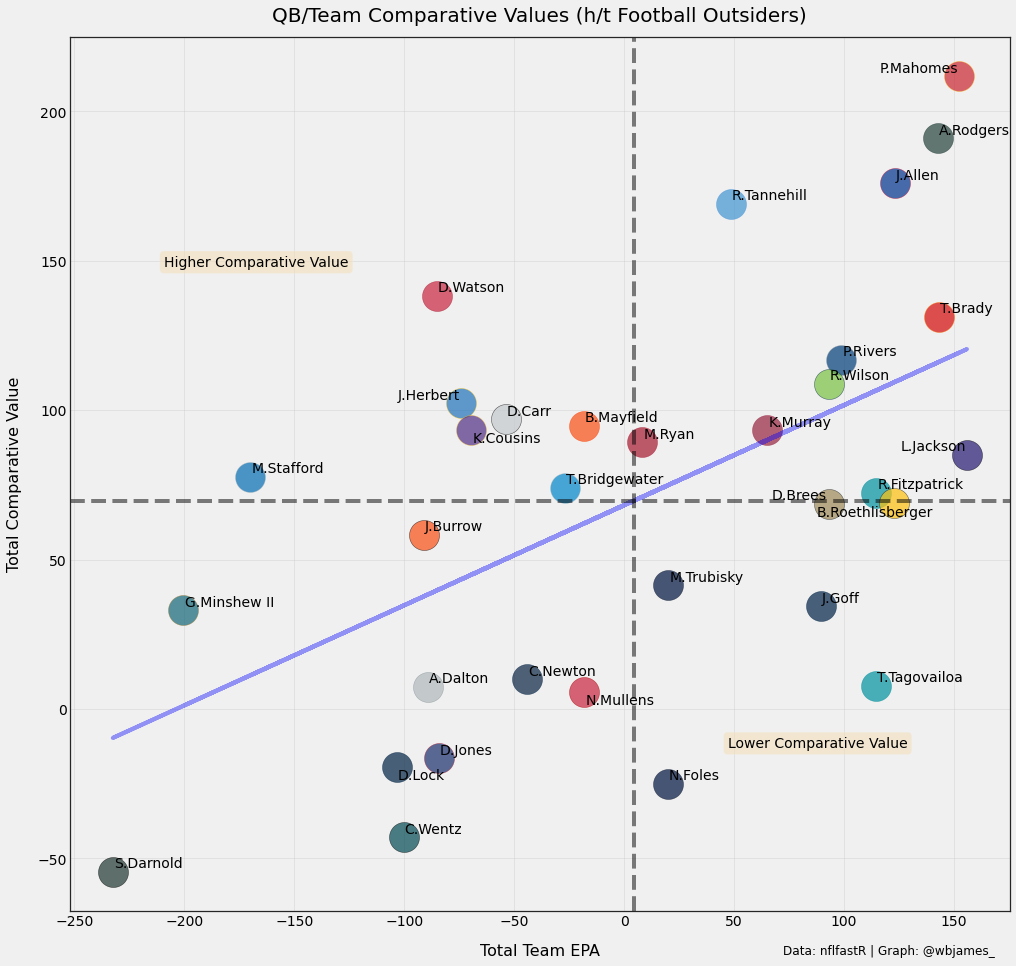

In [27]:

fig, ax = plt.subplots(figsize=(15,15)) #create figure
style.use('fivethirtyeight')
plt.plot(x, abline_values, 'b',alpha=.4)
ax.axvline(x=total['total'].mean(), linestyle='--', alpha=.5, color='black')#Create vertical and horizontal lines for averages of each metric
ax.axhline(y=total['tepa'].mean(), linestyle='--', alpha=.5, color='black')

#Create a dot for each player
#Find their team color in the COLORS dictionary
#s stands for size, the dot size is proportional to the QBs number of plays
for i in range(len(total)): 
    ax.scatter(total['total'].iloc[i],total['tepa'].iloc[i],
               s=900, alpha=.7,
               color=COLORS[total['team'].iloc[i]], edgecolor = COLORS2[total['team'].iloc[i]])
texts = [plt.text(x0,y0,name,ha='right',va='bottom') for x0,y0,name in zip(
total['total'], total['tepa'], total['passer'])]
adjust_text(texts)
ax.grid(zorder=0,alpha=.4)
ax.set_axisbelow(True)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr = 'Higher Comparative Value'
textstr2 = 'Lower Comparative Value'

ax.text(0.1, 0.75, textstr, transform=ax.transAxes, fontsize=14, #text box 
        verticalalignment='top', bbox=props)

ax.text(0.7, 0.20, textstr2, transform=ax.transAxes, fontsize=14, #text box
        verticalalignment='top', bbox=props)


plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = "1.25"
#Add title, labels, and source
ax.set_title('QB/Team Comparative Values (h/t Football Outsiders)',fontsize=20,pad=15)
ax.set_xlabel('Total Team EPA',fontsize=16,labelpad=15)
ax.set_ylabel('Total Comparative Value',fontsize=16,labelpad=15)
plt.figtext(.74,.03,'Data: nflfastR | Graph: @wbjames_',fontsize=12)
